In [2]:
import numpy as np
import pandas as pd
import os
import json
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle

2024-10-02 22:55:20.583445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 22:55:20.593840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 22:55:20.597022: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 22:55:20.605637: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 22:55:21.159826: W tensorflow/compiler/tf2

In [3]:
sr = 22050
TOTAL_SAMPLES = 29 * sr

NUM_SLICES = 6
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [4]:
def preprocess_data_MFCC(source_path, json_path):

    # Dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "mfcc": []
        }

    # Browse each file, slice it and generate the 128 band mfcc for each slice.
    for i, (dirpath,dirname, filenames) in enumerate(os.walk(source_path)):
        for file in filenames:
            # exclude a corrupted wav file that makes everything crash.
            if os.path.join(dirpath, file) != 'genres_original/jazz/jazz.00054.wav':
                song, sr = librosa.load(os.path.join(dirpath, file), duration=29)

                # Compute MFCC
                mfcc = librosa.feature.mfcc(y=song, sr=sr, n_mfcc=128)
                mfcc = mfcc.T

                mydict["labels"].append(i-1)
                mydict["mfcc"].append(mfcc.tolist())
            else:
                pass

    # Write the dictionary in a json file.    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [5]:
def preprocess_data_STFT(source_path, json_path):

    # Dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "stft": [] 
        }

    for i, (dirpath,dirname, filenames) in enumerate(os.walk(source_path)):
        for file in filenames:
            # exclude a corrupted wav file that makes everything crash.
            if os.path.join(dirpath, file) != 'genres_original/jazz/jazz.00054.wav':
                song, sr = librosa.load(os.path.join(dirpath, file), duration=29)

                # Compute STFT
                stft = np.abs(librosa.stft(song,n_fft=1536,hop_length=1024))
                stft = stft.T

                mydict["labels"].append(i-1)
                mydict["stft"].append(stft.tolist())
            else:
                pass

    # Write the dictionary in a json file.    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [6]:
def load_data_MFCC(json_path):
    # Load the JSON data from the file
    with open(json_path, 'r') as f:
        data = json.load(f)

    x = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return x, y

In [7]:
def load_data_STFT(json_path):
    # Load the JSON data from the file
    with open(json_path, 'r') as f:
        data = json.load(f)

    x = np.array(data["stft"])
    y = np.array(data["labels"])

    return x, y

In [8]:
def prepare_datasets(inputs, targets, split_size):
    
    # Creating a validation set and a test set.
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size)
    
    # Our CNN model expects 3D input shape.
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [9]:
def design_model(input_shape_MFCC, input_shape_STFT):

    # Define the MFCC branch (x1)
    input_MFCC = tf.keras.Input(shape=input_shape_MFCC)
    x1 = tf.keras.layers.Conv2D(20, (16, 16), activation='relu')(input_MFCC)
    x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    
    x1 = tf.keras.layers.Conv2D(22, (13, 13), activation='relu', padding='same')(x1)
    x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    
    x1 = tf.keras.layers.Conv2D(26, (8, 8), activation='relu', padding='same')(x1)
    x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)

    x1 = tf.keras.layers.Conv2D(38, (7, 7), activation='relu', padding='same')(x1)
    x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)

    x1 = tf.keras.layers.Conv2D(39, (4, 4), activation='relu', padding='same')(x1)
    x1 = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Dropout(0.4)(x1)
    
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(200, activation='relu')(x1)
    
    # Define the STFT branch (x2)
    input_STFT = tf.keras.Input(shape=input_shape_STFT)
    x2 = tf.keras.layers.Conv2D(31, (15, 15), activation='relu')(input_STFT)
    x2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    
    x2 = tf.keras.layers.Conv2D(38, (11, 11), activation='relu', padding='same')(x2)
    x2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    
    x2 = tf.keras.layers.Conv2D(43, (9, 9), activation='relu', padding='same')(x2)
    x2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)

    x2 = tf.keras.layers.Conv2D(57, (6, 6), activation='relu', padding='same')(x2)
    x2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)

    x2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    x2 = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Dropout(0.4)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Dense(200, activation='relu')(x2)

    # Concatenate both branches
    merged = tf.keras.layers.Concatenate()([x1, x2])

    # Output layer
    output = tf.keras.layers.Dense(10, activation='softmax')(merged)

    # Create the model
    model = tf.keras.Model(inputs=[input_MFCC, input_STFT], outputs=output)
    
    return model

In [10]:
def make_prediction(model, X, y, idx):
    
    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "country",
        3 : "disco",
        4 : "hiphop",
        5 : "jazz",
        6 : "metal",
        7 : "pop",
        8 : "reggae",
        9 : "rock",
        }
        
    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])
    
    print("\n---Now testing the model for one audio file---\nThe model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))

In [11]:
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["acc"], label="train accuracy")
    axs[0].plot(hist.history["val_acc"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

In [12]:
if not os.path.exists("mfcc.json"):
    preprocess_data_MFCC(source_path="genres_original", json_path="mfcc.json")
else:
    print("File already exists, skipping preprocessing.")

File already exists, skipping preprocessing.


In [13]:
if not os.path.exists("stft.json"):
    preprocess_data_STFT(source_path="genres_original", json_path="stft.json")
else:
    print("File already exists, skipping preprocessing.")

File already exists, skipping preprocessing.


In [14]:
inputs_MFCC, targets_MFCC = load_data_MFCC(json_path="mfcc.json")

In [15]:
inputs_MFCC.shape

(999, 1249, 128)

In [16]:
inputs_STFT, targets_STFT= load_data_STFT(json_path="stft.json")

In [17]:
inputs_STFT.shape

(999, 625, 769)

In [18]:
song,sr=librosa.load("genres_original/jazz/jazz.00053.wav",duration=29)
stft= np.abs(librosa.stft(song,n_fft=1536,hop_length=1024)).T
stft.shape

(625, 769)

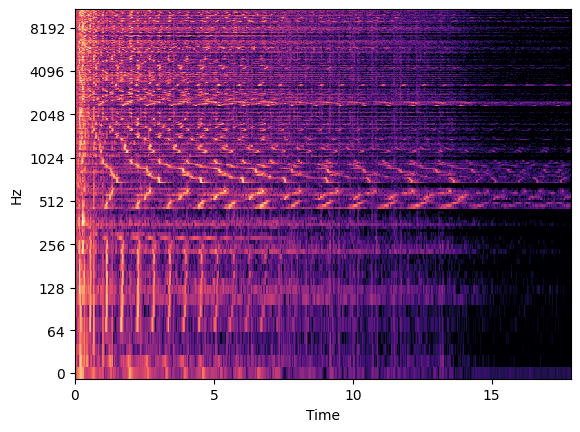

In [19]:
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(stft,ref=np.max),y_axis="log",x_axis="time",ax=ax)

In [20]:
# Use either targets_STFT or targets_MFCC as the labels (they should be the same)
y = targets_STFT  # Assuming both target arrays are identical

# Ensure the labels are one-hot encoded for classification
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_onehot = label_binarizer.fit_transform(y)

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
inputs_MFCC_train, inputs_MFCC_val, inputs_STFT_train, inputs_STFT_val, y_train, y_val = train_test_split(
    inputs_MFCC, inputs_STFT, y_onehot, test_size=0.2, random_state=42
)

# Create the model
input_shape_MFCC = (inputs_MFCC_train.shape[1],inputs_MFCC_train.shape[2],1)  # Shape of MFCC input
input_shape_STFT = (inputs_STFT_train.shape[1],inputs_STFT_train.shape[2],1)  # Shape of STFT input
model = design_model(input_shape_MFCC, input_shape_STFT)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0025),
                     loss='categorical_crossentropy',
                     metrics = ['acc']
                     )


I0000 00:00:1727931498.391322   18513 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727931498.415508   18513 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727931498.418783   18513 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727931498.425434   18513 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [21]:
model.summary() 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1249, 128, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 625, 769,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1234, 113, │      5,140 │ input_layer[0][0] │
│                     │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 611, 755,  │      7,006 │ input_layer_1[0]… │
│                     │ 31)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 617, 57,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 306, 378,  │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 31)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 617, 57,   │         80 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 306, 378,  │        124 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │ 31)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 617, 57,   │     74,382 │ batch_normalizat… │
│                     │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 306, 378,  │    142,576 │ batch_normalizat… │
│                     │ 38)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 309, 29,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 153, 189,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 38)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 309, 29,   │         88 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 153, 189,  │        152 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │ 38)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 309, 29,   │     36,634 │ batch_normalizat… │
│                     │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 153, 189,  │    132,397 │ batch_normalizat… │
│                     │ 43)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 155, 15,   │          0 │ conv2d_2[0][0]  

 Total params: 7,958,247 (30.36 MB)

 Trainable params: 7,957,491 (30.36 MB)

 Non-trainable params: 756 (2.95 KB)

In [22]:
history = model.fit(
    [inputs_MFCC_train, inputs_STFT_train],  # The two inputs for the model
    y_train,  # The target labels
    validation_data=([inputs_MFCC_val, inputs_STFT_val], y_val),
    epochs=75,
    batch_size=8
    )


Epoch 1/75


I0000 00:00:1727931502.582734   18672 service.cc:146] XLA service 0x75bf00008ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727931502.582903   18672 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-10-02 22:58:22.663322: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-02 22:58:22.974781: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-02 22:58:32.761014: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[8,31,306,378]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,38,306,378]{3,2,1,0}, f32[38,31,11,11]{3,2,1,0}), window={size=11x11 pad=5_5x5_5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operati

  1/100 ━━━━━━━━━━━━━━━━━━━━ 57:20 35s/step - acc: 0.0000e+00 - loss: 4.4460

2024-10-02 22:58:55.002415: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_8', 56 bytes spill stores, 56 bytes spill loads

I0000 00:00:1727931535.028892   18672 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - acc: 0.1874 - loss: 30.8191

2024-10-02 22:59:31.142325: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[38,31,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,31,306,378]{3,2,1,0}, f32[7,38,306,378]{3,2,1,0}), window={size=11x11 pad=5_5x5_5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-02 22:59:31.637410: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.495166324s
Trying algorithm eng0{} for conv (f32[38,31,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,31,306,378]{3,2,1,0}, f32[7,38,306,378]{3,2,1,0}), window={size=11x11 pad=5_5x5_5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wai

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - acc: 0.1878 - loss: 30.6518

2024-10-02 22:59:39.100608: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_8', 56 bytes spill stores, 56 bytes spill loads



100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 506ms/step - acc: 0.1882 - loss: 30.4878 - val_acc: 0.2450 - val_loss: 66.3173
Epoch 2/75
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - acc: 0.2585 - loss: 3.2396 - val_acc: 0.1500 - val_loss: 14.6077
Epoch 3/75
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - acc: 0.3007 - loss: 2.0831 - val_acc: 0.2300 - val_loss: 11.9640
Epoch 4/75
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - acc: 0.3411 - loss: 2.4522 - val_acc: 0.3250 - val_loss: 2.8133
Epoch 5/75
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - acc: 0.3893 - loss: 1.6483 - val_acc: 0.4250 - val_loss: 1.8614
Epoch 6/75
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - acc: 0.4224 - loss: 1.6478 - val_acc: 0.2850 - val_loss: 4.9868
Epoch 7/75
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - acc: 0.4433 - loss: 1.5480 - val_acc: 0.4200 - val_loss: 2.3634
Epoch 8/75
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - acc: 0.4670 - loss: 1.5145 - val_acc: 0.2150 - val_loss: 6.6399
Epoch 9/75
100/100 ━━━━━━━━━━━━━━━━━━━━

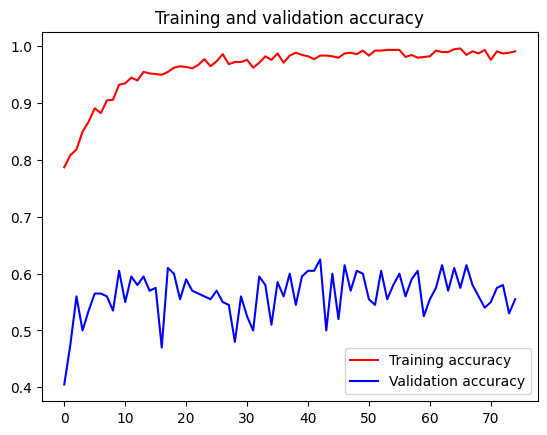

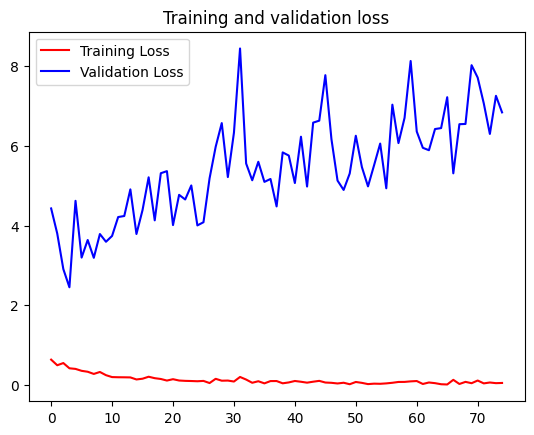

In [27]:
plot_performance(history)

In [23]:
train_accuracy = history.history['acc'][-1]  # Last epoch accuracy
test_accuracy = history.history['val_acc'][-1]  # Last epoch validation accuracy

# Print accuracies
print('Training accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

Training accuracy: 0.7897371649742126
Test accuracy: 0.574999988079071


<Figure size 2000x1500 with 0 Axes>

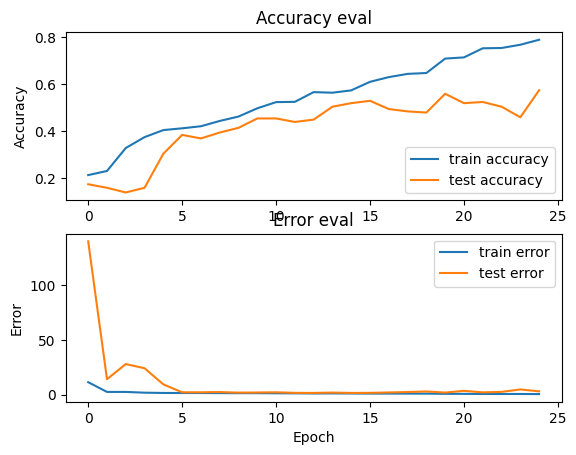

In [24]:
plot_history(history)

In [25]:
# Save the model to a file
with open('CNN4.pkl', 'wb') as file:
    pickle.dump(model, file)